## CS 510: Analytics and Data Science
### NLP Data Science Project: Sarcasm in Reddit Comments 

Repurposing Jupyter Notebook from Linguistics course:  
Updates coming soon.

### Part 1. Identify POS Tags in 2007 Text Messages:
Here are the instructions from the assignment for Part 1: 

    a. Underline the inserts.  Circle function words.  For lexical words, categorize them as noun, verb, adjective or adverb. 
	   (Write N, V, Adj, or Adv above each lexical word.)
    b. Count each class (N, V, Adj, Adv, inserts, function words) and record the count.  These are your raw counts.
    c. Count every word to get a total word count. Do not just total your counts of classes. 
       Instead, use this as a way to confirm your counting. Do your counts of each class make this total? 
       If not, figure out where your mistakes are.
             
We have created a script that will automatically identify the word classes as instructed above, calculate totals, 
and create a stacked bar chart for analysis.

##### Approach: 
We Iterate thru each text message in our 2007 Text Message Corpus and tag the PART-OF-SPEECH of each word.

<b>NOTE:</b> We could have written this code to simply get the counts on the whole corpus,
but for this assignment, message level analysis made it easier to confirm with manual counts.

This is how the tagset would look like if we simply used the upenn tagset:<br>
Counter({'NOUN': 29, 'VERB': 12, 'ADP': 9, 'ADV': 8, 'PRON': 8, '.': 7, 'DET': 4, 'ADJ': 3, 'CONJ': 2})

However, in order to satisfy the requirements, we need to modify our tagset as follows:
1. Inserts: Check if a word is in our inserts set, if so set POS tag to INSERT
2. Function Words: Combine ADP, PRON, DET, CONJ into FUNCTOR
3. Remove Punctuation

Alright, let's begin!

### Load Dependencies
#### Import the required packages (install them if you haven't already)

In [1]:
import sys
import nltk
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, HTML

plt.rcdefaults()
#%matplotlib inline
%matplotlib notebook

Display my Python Package Library versions and verify software dependencies loaded:

In [2]:
print(f"sys.version: {sys.version}")
print(f"NLTK: {nltk.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

#print(f"Scipy: {sp.__version__}")
#print(f"nose: {nose.__version__}")

sys.version: 3.7.5 (tags/v3.7.5:5c02a39a0b, Oct 15 2019, 00:11:34) [MSC v.1916 64 bit (AMD64)]
NLTK: 3.4.5
Numpy: 1.17.3
Pandas: 0.25.3
matplotlib: 3.1.1


#### Load Natural Language Processing Tool Kit (NLTK) Package
Load the following Part-of-Speech (POS) Taggers from the Natural Language Toolkit Library:

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('tagsets')
# Show definition of tags
# tagset_upenn = nltk.help.upenn_tagset()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

<b>NOTE ON FUNCTION WORDS:</b><br>
With respect to Function Words, we explored using the [NLTK Stopword corpus](https://www.nltk.org/book/ch02.html#stopwords_index_term)
when it was revealed to us that the NLTK's Stopword corpus, despite varying by domain, is basically 
[a manually currated 'general purpose' list of function words](https://stackoverflow.com/questions/41811790/function-vs-content-words#41813460)
 freely available to use in our tagger.

The other method we tried was mapping tags of pars of speech that closely resembled the different types of words that 
closely resemnbled function words (as defined in the the Longman textbook).  We have listed the POS Tags below that 
we combined into one 'FUNCTOR' POS Tag.
 
| Longman POS          | NLTK POS       | NLTK POS Tag    | Function Word Tag (New) |
| :-------------------:|:--------------:| :--------------:|:-----------------------:|
| Prepositions         | Adpositions    | ADP             | FUNCTOR                 |
| Pronouns             | Pronouns       | PRON            | FUNCTOR                 |
| Determiners          | Determiners    | DET             | FUNCTOR                 |
| Coordinators / </br> Subordinators   | Conjunctions | CONJ | FUNCTOR              |
| *Auxiliary Verbs     |      -         |       -         |  Not Implemented        |  
| *Adverbial Particles |      -         |       -         |  Not Implemented        |  

*We did not get have enough time to implement Auxiliary and Adverbial Particle detection.

Ultimately we went with Stopwords, because the counts we were getting were closer to what the instructor reported.

#### Load Corpora:

##### Insert Words
We did not make an exhastive list of insert words.  

In [4]:
insert_words = ('yeah', 'Ok', 'ahh', 'yeah', 'bye')
insert_words = set(w.lower() for w in insert_words)

# Use NLTK Stopwords to detect Function Words
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

messages = ['Gym?',
            'yeah be there in about a half',
            'Ok see you when you get here!',
            'Seconds away',
            'Meet me between smith and cramer asap',
            'I got you and Taylor tix in pit section.',
            'Get some milk please',
            'Chk email',
            'Made it',
            'Do u know where u saved that movie on my compute',
            'Im meeting some dude from the internet for happy hour ahh!',
            'Wed is dinner for renetta call us soon',
            'where r u???',
            'pinball']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tag each word with a Part-of-Speech (POS)
Iterate thru each text message in our 2007 Text Message Corpus and tag the PART-OF-SPEECH of each word.

In [5]:
counter_list = []
words = defaultdict(list)
words_stops = []
messages_list_tagged_custom = []

for msg in messages:
    tokens = nltk.word_tokenize(msg)
    #tokens = [w for w in tokens if w not in stopwords_fw] 
    
    msg_tagged = nltk.pos_tag(tokens, tagset='universal')
    print(f"\nMessage (RAW): {msg}")
    print(f"Message (NLTK   POS Tagged): {msg_tagged}")

    msg_tagged_custom = []
    # Build a dictionary of words, grouped by POS
    for w, tag in msg_tagged:
        # NOTE: We are just keeping track of stopwords and reporting in addition to the other tags
        # words that are tagged as 'STOPS' will also have their regular POS Tag
        if w.lower() in stopwords:
            #words_stops.append(w)
            tag = 'FUNCTOR'
        elif w.lower() in insert_words:
            tag = 'INSERT'
        elif tag in ('PRON', 'DET', 'ADP', 'CONJ'):
            tag = 'FUNCTOR'
        elif tag == '.':
            continue

        words[tag].append(w)
        msg_tagged_custom.append((w, tag))

    messages_list_tagged_custom.append(msg_tagged_custom)
    print(f"Message (Custom POS Tagged): {msg_tagged_custom}")


Message (RAW): Gym?
Message (NLTK   POS Tagged): [('Gym', 'NOUN'), ('?', '.')]
Message (Custom POS Tagged): [('Gym', 'NOUN')]

Message (RAW): yeah be there in about a half
Message (NLTK   POS Tagged): [('yeah', 'ADV'), ('be', 'VERB'), ('there', 'ADV'), ('in', 'ADP'), ('about', 'ADP'), ('a', 'DET'), ('half', 'NOUN')]
Message (Custom POS Tagged): [('yeah', 'INSERT'), ('be', 'FUNCTOR'), ('there', 'FUNCTOR'), ('in', 'FUNCTOR'), ('about', 'FUNCTOR'), ('a', 'FUNCTOR'), ('half', 'NOUN')]

Message (RAW): Ok see you when you get here!
Message (NLTK   POS Tagged): [('Ok', 'NOUN'), ('see', 'VERB'), ('you', 'PRON'), ('when', 'ADV'), ('you', 'PRON'), ('get', 'VERB'), ('here', 'ADV'), ('!', '.')]
Message (Custom POS Tagged): [('Ok', 'INSERT'), ('see', 'VERB'), ('you', 'FUNCTOR'), ('when', 'FUNCTOR'), ('you', 'FUNCTOR'), ('get', 'VERB'), ('here', 'FUNCTOR')]

Message (RAW): Seconds away
Message (NLTK   POS Tagged): [('Seconds', 'VERB'), ('away', 'ADV')]
Message (Custom POS Tagged): [('Seconds', 'VER

#### Sum of totals:

In [6]:
counter_pos = {k: len(v) for k,v in words.items()}
total_words = sum(counter_pos.values())

print(f"\nPOS Counts: {counter_pos}")
print(f"\nTotal Words: {total_words}")
print(f"Total NLTK Stopwords: {len(words_stops)}")


POS Counts: {'NOUN': 27, 'INSERT': 3, 'FUNCTOR': 31, 'VERB': 9, 'ADV': 2, 'ADJ': 3}

Total Words: 75
Total NLTK Stopwords: 0


#### Summary: Words grouped by POS:

In [7]:
row_labels = ['Nouns', 'Verbs', 'Adjectives', 'Adverbs', 'Function Words', 'INSERT', '*Stopwords']
words_by_pos = [ ', '.join(words['NOUN']), ', '.join(words['VERB']), ', '.join(words['ADJ']), ', '.join(words['ADV']), 
                 ', '.join(words['FUNCTOR']), ', '.join(words['INSERT']), ', '.join(words_stops) ]   
data = {'Word Class': row_labels,
        'Words': words_by_pos}
df = pd.DataFrame(data, columns=['Word Class', 'Words'])

# Set table styles
styles = [ dict(selector="th", props=[('text-align', 'center')]),
           dict(selector="th", props=[('white-space', 'nowrap')]),
           dict(selector="td", props=[('text-align', 'left')]) ]
styled_df = (df.style
             .set_properties(subset=df.columns[0],  **{'white-space':'nowrap'})
             .set_table_styles(styles))

html = styled_df.hide_index().render()
display(HTML(html))

Word Class,Words
Nouns,"Gym, half, smith, cramer, asap, Taylor, tix, section, milk, please, Chk, email, u, movie, compute, Im, meeting, dude, internet, hour, Wed, dinner, renetta, call, r, u, pinball"
Verbs,"see, get, Seconds, Meet, got, Get, Made, know, saved"
Adjectives,"pit, u, happy"
Adverbs,"away, soon"
Function Words,"be, there, in, about, a, you, when, you, here, me, between, and, I, you, and, in, some, it, Do, where, that, on, my, some, from, the, for, is, for, us, where"
INSERT,"yeah, Ok, ahh"
*Stopwords,


*NLTK Stopwords are provided for the instructor to evaluate how well it identifies function words.

### Part 2.  Calculate Percentages, Normed Frequencies, and Plot Stacked Bar Chart
Here are the instructions from the assignment for Part 2: 

    a. Calculate percentages.  What percentage of the total words are lexical words? Function words?  Inserts?  
    b. Calculate normed frequencies per 1000 words for the lexical classes.  Make a quick figure like Figure 2.1. 
       This is a stacked bar.
             

In [8]:
# Gather Counts
raw_counts = counter_pos
percentages = {pos: wc / total_words for pos, wc in raw_counts.items()}
norm_counts = {pos: wc / total_words * 1000 for pos, wc in raw_counts.items()}

row_labels = ['Nouns', 'Verbs', 'Adjectives', 'Adverbs', 'Function Words', 'INSERT']
raw_counts_list = [ counter_pos['NOUN'], counter_pos['VERB'], counter_pos['ADJ'], counter_pos['ADV'], 
                    counter_pos['FUNCTOR'], counter_pos['INSERT'], ]

percentages_list = [ percentages['NOUN'], percentages['VERB'], percentages['ADJ'], percentages['ADV'], 
                     percentages['FUNCTOR'], percentages['INSERT'], ]

norm_counts_list = [ norm_counts['NOUN'], norm_counts['VERB'], norm_counts['ADJ'], norm_counts['ADV'], 
                     norm_counts['FUNCTOR'], norm_counts['INSERT'], ]

data = {'Word Class': row_labels,
        'Raw Counts': raw_counts_list,
        'Percentages':percentages_list,
        'Normed per 1000': norm_counts_list }

df = pd.DataFrame(data, columns=['Word Class', 'Raw Counts', 'Percentages', 'Normed per 1000'])
df.loc[df.index.max()+1]=['Total']+df.sum().tolist()[1:]

# Construct a mask of which columns are numeric
numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, np.number))
# Set table styles
styles = [ dict(selector="th", props=[('text-align', 'center')]) ]

styled_df = (df.style
                # Format the percentage and Normed per 1000 fields
                .format({'Percentages': "{:.1%}",  'Normed per 1000': "{:,.1f}"})
                # right-align the numeric columns and set their width
                .set_properties(subset=df.columns[numeric_col_mask],  **{'text-align':'right'})
                # left-align the non-numeric columns and set their width
                .set_properties(subset=df.columns[~numeric_col_mask], **{'text-align':'left'})
                # center the header
                .set_table_styles(styles) 
            )

html = styled_df.hide_index().render()
display(HTML(html))

Word Class,Raw Counts,Percentages,Normed per 1000
Nouns,27,36.0%,360.0
Verbs,9,12.0%,120.0
Adjectives,3,4.0%,40.0
Adverbs,2,2.7%,26.7
Function Words,31,41.3%,413.3
INSERT,3,4.0%,40.0
Total,75,100.0%,"1,000.0"


### Plot Stacked Bar Chart
Create a stacked bar graph displaying the raw counts, percentages, and normed frequencies per 1000 words for the lexical classes.

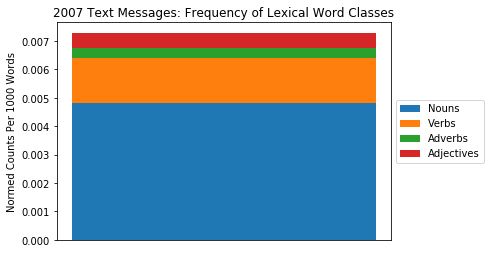

In [9]:
# Graph it!
width = 0.7

raw_counts = counter_pos
percentages = {pos: wc / total_words for pos, wc in raw_counts.items()}
norm_counts = {pos: pct / total_words for pos, pct in percentages.items()}

p1 = plt.bar(width=width, x=1, height=norm_counts['NOUN'])
p2 = plt.bar(width=width, x=1, height=norm_counts['VERB'], bottom=norm_counts['NOUN'])
p3 = plt.bar(width=width, x=1, height=norm_counts['ADV'], bottom=norm_counts['NOUN'] + norm_counts['VERB'])
p4 = plt.bar(width=width, x=1, height=norm_counts['ADJ'], bottom=norm_counts['NOUN'] + norm_counts['VERB'] + norm_counts['ADV'])

plt.ylabel('Normed Counts Per 1000 Words')
plt.title('2007 Text Messages: Frequency of Lexical Word Classes')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

max_y_value = total_words * 1000
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=(p1[0], p2[0], p3[0], p4[0]), labels=('Nouns', 'Verbs', 'Adverbs', 'Adjectives'))
#plt.autoscale(False)

### Part 3.  Summary
Answer the research questions.  Writing out the answer is your Text Analysis 1 assignment.

The research questions (slightly reworded from the class handout – use these):
1.  *If this sample is typical, did text messages in 2007 consist almost exclusively of lexical words, 
     as was many people’s intuition?*

    No.  Out of 75 words, 41% of them were function words. I had assumed with a T9 (Text on 9 Keys) numeric keypad,
    there would have been a lot less function words. The counts suggest otherwise.

2.  *How do the proportions of the lexical word classes in the text messages compare to the proportions in the 
    registers in Figure 2.1 of the SG (p. 23)?* 
    
    *That is, would you say text messages are like one of those registers in their lexical word class use?  Explain.*

    In order to make such a comparison, we need to compare just the proportions of the lexical word classes to in 
    our stacked bar chart to the Figure 2.1.  My assumption is that the text messages would be more like the 
    conversational register than any of the others, since text messaging is a form of conversation.  However, the
    word counts that this script produces does not really match any of the registers that we see in Figure 2.1.
    
    If we compare the instructor counts that were provided in class with Figure 2.1, we can see that it closely 
    resembles the conversational register.  This descrepancy, between script counts and the instructor counts, 
    would be a good topic for further discussion.

